In [1]:
from fastai.vision.all import *
import fastai

In [2]:
path = untar_data(URLs.PASCAL_2007, archive='D:\FastAi_Data')

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
dblock = DataBlock()

In [5]:
dsets = dblock.datasets(df)

In [6]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [7]:
x,y = dsets.train[0]
x

fname       004209.jpg
labels      dog person
is_valid         False
Name: 2117, dtype: object

In [8]:
x['fname']

'004209.jpg'

In [9]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('001064.jpg', 'horse person')

In [10]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/adima/.fastai/data/pascal_2007/train/003811.jpg'),
 ['boat', 'person'])

In [11]:
dblock = DataBlock(blocks=(ImageBlock,MultiCategoryBlock), get_x= get_x, get_y= get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
                      0., 0., 0., 0., 0.]))

In [12]:
idxs = torch.where(dsets.train[0][1] ==1.0)[0]
dsets.train.vocab[idxs]

(#3) ['diningtable','dog','person']

In [13]:
idxs

TensorMultiCategory([10, 11, 14])

In [14]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y, 
                  splitter=splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [15]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y
                  , splitter = splitter, item_tfms = RandomResizedCrop(128, min_scale = 0.35))
dls = dblock.dataloaders(df)

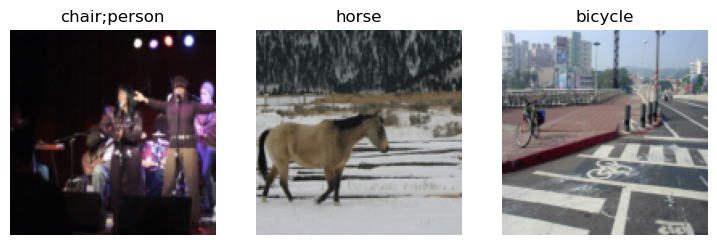

In [16]:
dls.show_batch(nrows = 1, ncols = 3)

In [17]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      C:\Users\adima\.fastai\data\pascal_2007\tr

In [18]:
path.ls()

(#8) [Path('C:/Users/adima/.fastai/data/pascal_2007/segmentation'),Path('C:/Users/adima/.fastai/data/pascal_2007/test'),Path('C:/Users/adima/.fastai/data/pascal_2007/test.csv'),Path('C:/Users/adima/.fastai/data/pascal_2007/test.json'),Path('C:/Users/adima/.fastai/data/pascal_2007/train'),Path('C:/Users/adima/.fastai/data/pascal_2007/train.csv'),Path('C:/Users/adima/.fastai/data/pascal_2007/train.json'),Path('C:/Users/adima/.fastai/data/pascal_2007/valid.json')]

In [19]:
learn = vision_learner(dls, resnet18)

C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [21]:
activs[0]

TensorImage([-1.6608,  4.9253,  0.3883,  2.1893, -0.5492,  1.0113, -0.6904,
              0.3120,  2.9438, -1.6263, -1.0181, -0.2478, -3.3332,  3.6916,
              3.6044,  0.8264, -0.2946,  1.6162,  0.0636, -2.0380],
            grad_fn=<AliasBackward0>)

In [22]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets == 1, inputs, 1-inputs).log().mean()

In [24]:
TensorImage.register_func(torch.nn.functional.smooth_l1_loss, TensorImage, TensorBBox)
TensorMultiCategory.register_func(TensorMultiCategory.mul, TensorMultiCategory, TensorImage)
TensorImage.register_func(torch.nn.functional.binary_cross_entropy_with_logits, TensorImage, TensorMultiCategory)

In [25]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs,y)
loss

TensorImage(1.0862, grad_fn=<AliasBackward0>)

In [26]:
def say_hello(name, say_what='Hello'):
    return f"{say_what} {name}."
say_hello('Aditya'),say_hello('Aditya', 'Chao')

('Hello Aditya.', 'Chao Aditya.')

In [27]:
f = partial(say_hello, say_what="Namaste")
f("Aditya"),f('Arnav')

('Namaste Aditya.', 'Namaste Arnav.')

In [28]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [29]:
learn = vision_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh = 0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.932727,0.691751,0.248426,01:08
1,0.815125,0.565705,0.284382,00:41
2,0.596387,0.201852,0.814940,00:40
3,0.356458,0.123280,0.943107,00:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136394,0.120561,0.950598,00:44
1,0.116724,0.105741,0.950478,00:44
2,0.096583,0.101728,0.951155,00:44


In [30]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10172832012176514,0.9282668232917786]

In [32]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10172832012176514,0.9428085684776306]

In [33]:
preds, targs = learn.get_preds()

In [34]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9569)

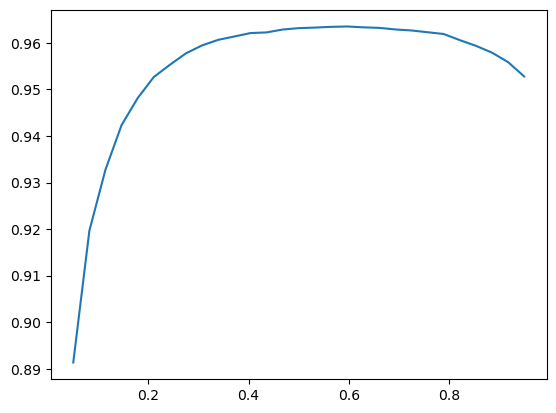

In [35]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds,targs, thresh=i,sigmoid=False) for i in xs]
plt.plot(xs,accs);

# Image Regression

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE, archive='D:\FastAi_Data')

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [7]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('01/frame_00003_pose.txt')

In [8]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

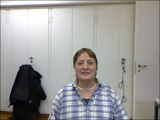

In [9]:
im.to_thumb(160)

In [10]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer = 6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [11]:
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [12]:
biwi = DataBlock(blocks= (ImageBlock, PointBlock),
                get_items=get_image_files,
                get_y = get_ctr,
                splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                batch_tfms = aug_transforms(size=(240,320))
                )

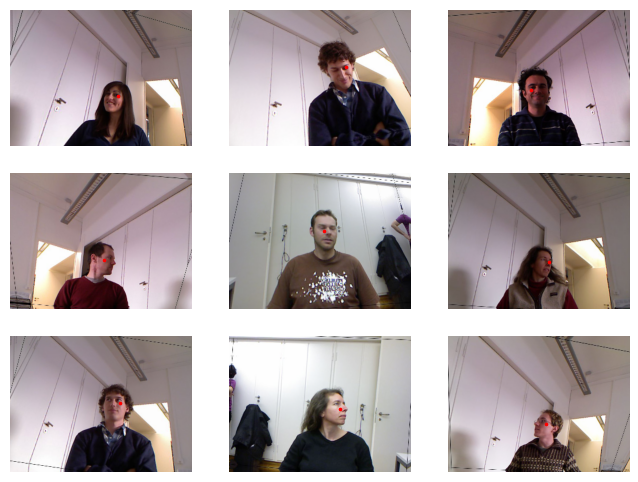

In [13]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [14]:
xb, yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [15]:
yb[0]

TensorPoint([[-0.0781,  0.0008]], device='cuda:0')

In [16]:
learn = vision_learner(dls,resnet18,y_range = (-1,1))

C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def sigmoid_range(x,lo,hi):
    return torch.sigmoid(x) * (hi-lo)+lo

In [2]:
!pip install -Uqq fastbook
import fastbook

In [23]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max,100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

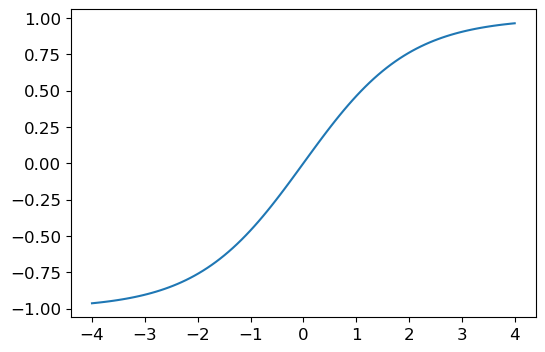

In [24]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [25]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

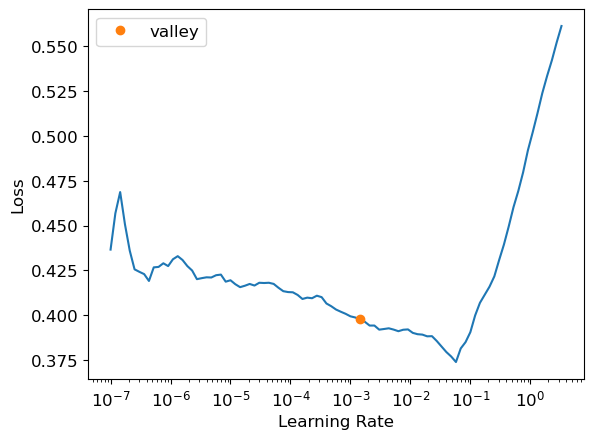

In [26]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3,lr)

epoch,train_loss,valid_loss,time


In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))